# Importing data

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.offline as pyoff
import plotly.graph_objs as go
import warnings
import statistics

In [ ]:
import io
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving DATA_2018_2021 V2.xlsx to DATA_2018_2021 V2.xlsx


In [ ]:
data = pd.read_excel(io.BytesIO(uploaded['DATA_2018_2021 V2.xlsx']))
data.head()

In [ ]:
data.describe()

# EDA

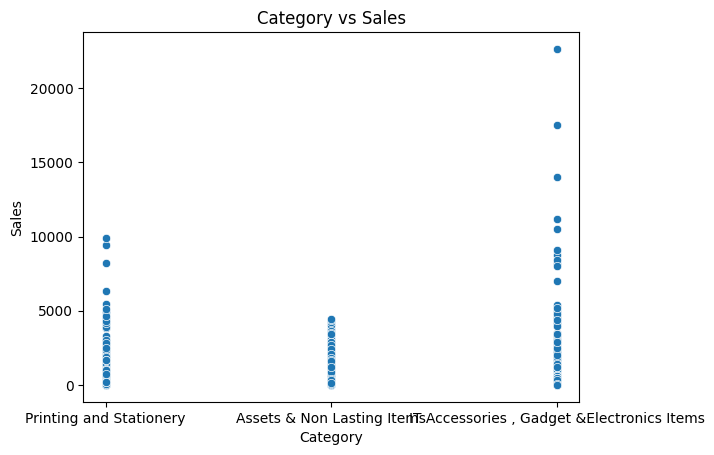

In [ ]:
sns.scatterplot(x = 'Category', y = 'Sales', data = data)
plt.title('Category vs Sales')
plt.show()

In [ ]:
grouped_data = data.groupby('Category')['Quantity'].sum().reset_index()
sorted_data = grouped_data.sort_values(by = 'Quantity', ascending = False)
print(sorted_data)

                                     Category  Quantity
2                     Printing and Stationery     22906
0                  Assets & Non Lasting Items      8028
1  IT Accessories , Gadget &Electronics Items      6939


In [ ]:
grouped_data = data.groupby('Category')['Sales'].sum().reset_index()
sorted_data = grouped_data.sort_values(by = 'Sales', ascending = False)
print(sorted_data)

                                     Category        Sales
1  IT Accessories , Gadget &Electronics Items  843539.0330
0                  Assets & Non Lasting Items  750460.7953
2                     Printing and Stationery  743089.0320


In [ ]:
grouped_data = data.groupby('Sub-Category')['Sales'].sum().reset_index()
sorted_data = grouped_data.sort_values(by = 'Sales', ascending = False)
print(sorted_data)

   Sub-Category        Sales
13       Phones  333576.0540
5        Chairs  330860.1030
14      Storage  227226.6080
3       Binders  209623.7330
16       Tables  208255.5320
11     Machines  189716.6310
0   Accessories  170465.3180
6       Copiers  149781.0300
4     Bookcases  115787.9963
1    Appliances  109410.1610
9   Furnishings   95557.1640
12        Paper   83843.2060
15     Supplies   47417.5380
2           Art   30322.7920
7     Envelopes   17512.4020
10       Labels   13896.3120
8     Fasteners    3836.2800


      Customer_ID  Mean
0           15146     3
1           13001     2
2           19196     3
3           19196     3
4           19196     2
...           ...   ...
9989        15416     7
9990        15416     3
9991        16601     2
9992        12431     2
9993        11186     8

[9994 rows x 2 columns]


(array([4520., 2318., 1844.,  628.,  425.,  121.,   64.,   19.,   38.,
          17.]),
 array([ 1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5, 26. ]),
 <BarContainer object of 10 artists>)

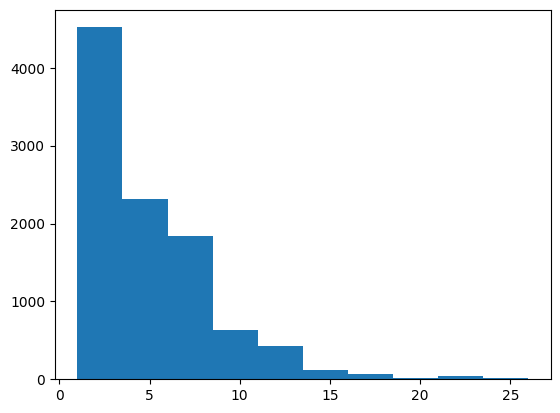

In [ ]:
data['Mean'] = data['Quantity'].groupby(data['Order_ID']).transform('sum')
print(data[['Customer_ID', 'Mean']])
plt.hist(data['Mean'])

# RFM Analysis

In [ ]:
data_IT = data[data['Category'] == 'IT Accessories , Gadget &Electronics Items']
data_Items = data[data['Category'] == 'Assets & Non Lasting Items']
data_Print = data[data['Category'] == 'Printing and Stationery']

data_ItemsPrint = data[(data.Category == 'Assets & Non Lasting Items') | (data.Category == 'IT Accessories , Gadget &Electronics Items')]

In [ ]:
# recency
sales_recency = data_Print.groupby(by = 'Customer_ID',
						as_index = False)['Order Date'].max()
sales_recency.columns = ['Customer_ID', 'Last Purchase Date']
recent_date = sales_recency['Last Purchase Date'].max()
sales_recency['Recency'] = sales_recency['Last Purchase Date'].apply(
	lambda x: (recent_date - x).days)
sales_recency

,Customer_ID,Last Purchase Date,Recency
0,10016,2018-03-07,1394
1,10031,2021-12-18,12
2,10046,2021-09-04,117
3,10061,2021-11-05,55
4,10076,2021-11-26,34
...,...,...,...
783,21866,2021-11-17,43
784,21881,2021-12-21,9
785,21896,2021-12-26,4
786,21911,2021-11-06,54


In [ ]:
# frequency
sales_frequency = data_Print.drop_duplicates().groupby(
	by=['Customer_ID'],as_index = False)['Order Date'].count()
sales_frequency.columns = ['Customer_ID', 'Frequency']
sales_frequency.head()


,Customer_ID,Frequency
0,10016,3
1,10031,7
2,10046,6
3,10061,12
4,10076,13


In [ ]:
# monetary
data_Print['Total'] = data_Print['Sales']*data_Print['Quantity']
sales_monetary = data_Print.groupby(by = 'Customer_ID', as_index = False)['Total'].sum()
sales_monetary.columns = ['Customer_ID', 'Monetary']
sales_monetary.head()

<ipython-input-10-8a944b687829>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Customer_ID,Monetary
0,10016,828.888
1,10031,3198.916
2,10046,2033.338
3,10061,19743.004
4,10076,3978.135


In [ ]:
# merging r, f and m
sales_rf = sales_recency.merge(sales_frequency, on = 'Customer_ID')
sales_rfm = sales_rf.merge(sales_monetary, on = 'Customer_ID').drop(columns = 'Last Purchase Date')

sales_rfm.head()

,Customer_ID,Recency,Frequency,Monetary
0,10016,1394,3,828.888
1,10031,12,7,3198.916
2,10046,117,6,2033.338
3,10061,55,12,19743.004
4,10076,34,13,3978.135


<Axes: >

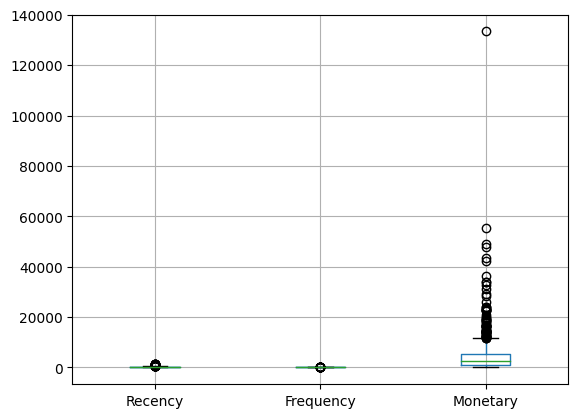

In [ ]:
# ranking cutomers based on rfm
sales_rfm['R_rank'] = sales_rfm['Recency'].rank(ascending = False)
sales_rfm['F_rank'] = sales_rfm['Frequency'].rank(ascending = True)
sales_rfm['M_rank'] = sales_rfm['Monetary'].rank(ascending = True)

# Assign R, F, and M buckets using pd.qcut()
sales_rfm['R_bucket'] = pd.qcut(sales_rfm['R_rank'], q = 5, labels=[5, 4, 3, 2, 1])
sales_rfm['F_bucket'] = pd.qcut(sales_rfm['F_rank'], q = 5, labels=[1, 2, 3, 4, 5])
sales_rfm['M_bucket'] = pd.qcut(sales_rfm['M_rank'], q = 5, labels=[1, 2, 3, 4, 5])

sales_rfm

sales_rfm.boxplot(column=['Recency', 'Frequency','Monetary'])



In [ ]:
sales_rfm['R_bucket'] = pd.to_numeric(sales_rfm['R_bucket'], errors='coerce')
sales_rfm['F_bucket'] = pd.to_numeric(sales_rfm['F_bucket'], errors='coerce')
sales_rfm['M_bucket'] = pd.to_numeric(sales_rfm['M_bucket'], errors='coerce')

In [ ]:
# 0.3, 0.5, 0.2 weights to R, F and M respectively because of the category (printing)
sales_rfm['RFM_Score'] = 0.3*sales_rfm['R_bucket'] + 0.5*sales_rfm['F_bucket'] + 0.2*sales_rfm['M_bucket']
sales_rfm = sales_rfm.round(2)

sales_rfm['RFM_Segment'] = sales_rfm.R_bucket.map(str) + sales_rfm.F_bucket.map(str) + sales_rfm.M_bucket.map(str)

In [ ]:
# change this
print ("Best Customers: ", len(sales_rfm[sales_rfm['RFM_Segment']=='111']))
print ("Loyal Customers:", len(sales_rfm[sales_rfm['F_bucket']==1]))
print ("Big Spenders:", len(sales_rfm[sales_rfm['M_bucket']==1]))
print ("Almost Lost:", len(sales_rfm[sales_rfm['RFM_Segment']=='134']))
print ("Lost Customers:", len(sales_rfm[sales_rfm['RFM_Segment']=='344']))
print ("Lost Cheap Customers:", len(sales_rfm[sales_rfm['RFM_Segment']=='444']))

Best Customers:  13
Loyal Customers: 192
Big Spenders: 158
Almost Lost: 9
Lost Customers: 6
Lost Cheap Customers: 13


rfm score >4.5 : Top Customer
4.5 > rfm score > 4 : High Value Customer
4>rfm score >3 : Medium value customer
3>rfm score>1.6 : Low-value customer
rfm score<1.6 :Lost Customer

In [ ]:
# rating customers based on rfm score
sales_rfm["Customer_Segment"] = np.where(sales_rfm['RFM_Score'] >
									4.5, "Top Customers",
									(np.where(
										sales_rfm['RFM_Score'] > 4,
										"High Value Customers",
										(np.where(
	sales_rfm['RFM_Score'] > 3,
							"Medium Value Customers",
							np.where(sales_rfm['RFM_Score'] > 1.6,
							'Low Value Customers', 'Lost Customers'))))))
sales_rfm[['Customer_ID', 'RFM_Score', 'Customer_Segment']].head(5)

,Customer_ID,RFM_Score,Customer_Segment
0,10016,2.4,Low Value Customers
1,10031,2.4,Low Value Customers
2,10046,2.5,Low Value Customers
3,10061,4.1,High Value Customers
4,10076,3.9,Medium Value Customers


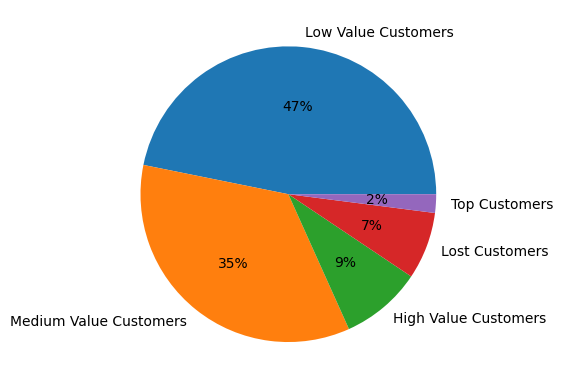

In [ ]:
# visualising the customer segments
plt.pie(sales_rfm.Customer_Segment.value_counts(),
		labels = sales_rfm.Customer_Segment.value_counts().index,
		autopct='%.0f%%')
plt.show()

sales_rfm = sales_rfm.drop(columns = ['R_bucket', 'F_bucket', 'M_bucket', 'RFM_Score', 'RFM_Segment', 'Customer_Segment'])

# Cluster Analysis

The location of each data point on the graph is determined by considering all information associated with the specific customer. If any of the information is not on the same distance scale, K-means might not form meaningful clusters for you.

In [ ]:
sales_rfm_new = sales_rfm.drop(columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary'])

scaler = MinMaxScaler()
scaler.fit(sales_rfm_new)
sales_rfm_scaled = scaler.transform(sales_rfm_new)

<Axes: >

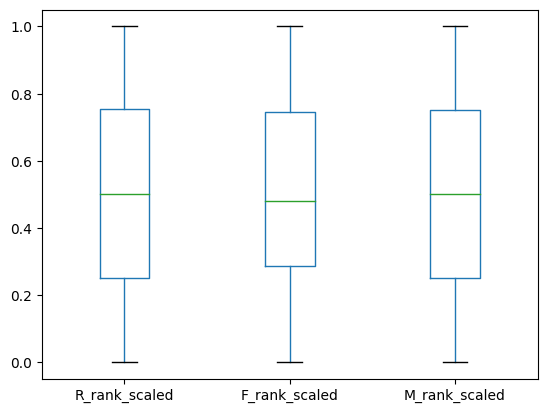

In [ ]:
sales_rfm_scaled = pd.DataFrame(sales_rfm_scaled, columns = ['R_rank_scaled', 'F_rank_scaled', 'M_rank_scaled'])
sales_rfm_scaled

sales_rfm_scaled.boxplot(column = ['R_rank_scaled', 'F_rank_scaled', 'M_rank_scaled'], grid=False)


<Axes: >

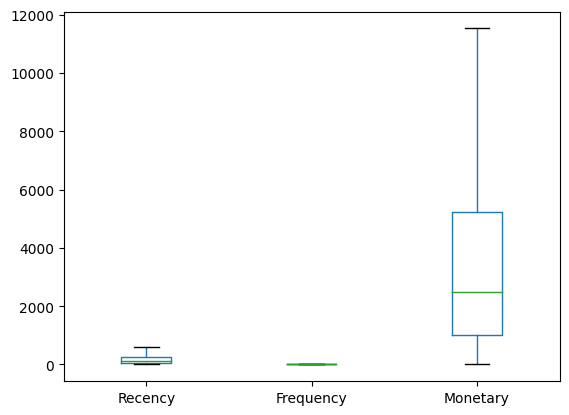

In [ ]:
sales_rfm.boxplot(column = ['Recency', 'Frequency', 'Monetary'], grid=False, showfliers = False)

In [ ]:
# x = sales_rfm.drop(columns = ['Customer_ID', 'R_rank', 'F_rank', 'M_rank'])
# plt.boxplot(x, showfliers=False)

In [ ]:
extracted_cols1 = sales_rfm_scaled['R_rank_scaled']
sales_rfm = sales_rfm.join(extracted_cols1)

extracted_cols2 = sales_rfm_scaled['F_rank_scaled']
sales_rfm = sales_rfm.join(extracted_cols2)

extracted_cols3 = sales_rfm_scaled['M_rank_scaled']
sales_rfm = sales_rfm.join(extracted_cols3)

sales_rfm

,Customer_ID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_scaled,F_rank_scaled,M_rank_scaled
0,10016,1394,3,828.89,1.0,85.5,167.0,0.000000,0.096463,0.210928
1,10031,12,7,3198.92,728.5,383.5,451.0,0.926162,0.479743,0.571792
2,10046,117,6,2033.34,350.5,313.0,344.0,0.444940,0.389068,0.435832
3,10061,55,12,19743.00,526.5,686.0,763.0,0.669001,0.868810,0.968234
4,10076,34,13,3978.14,619.5,712.5,509.0,0.787397,0.902894,0.645489
...,...,...,...,...,...,...,...,...,...,...
783,21866,43,21,4934.91,570.0,782.5,573.0,0.724379,0.992926,0.726811
784,21881,9,8,42208.79,738.5,455.5,783.0,0.938892,0.572347,0.993647
785,21896,4,5,22683.60,769.5,234.0,768.0,0.978358,0.287460,0.974587
786,21911,54,17,7454.43,532.5,765.0,660.0,0.676639,0.970418,0.837357


In [ ]:
rfm = sales_rfm[['R_rank_scaled','F_rank_scaled','M_rank_scaled']]

# First : Get the Best KMeans
ks = range(1,8)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k, random_state=1)
    kc.fit(rfm)
    inertias.append(kc.inertia_)
# Plot ks vs inertias
f, ax = plt.subplots(figsize = (15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans?')
plt.show()

In [ ]:
# Clustering
kc = KMeans(n_clusters = 4, random_state = 1)
kc.fit(sales_rfm[['R_rank_scaled','F_rank_scaled','M_rank_scaled']])
# Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

In [ ]:
# Calculate average RFM values and size for each cluster:
sales_rfm = sales_rfm.assign(Cluster = cluster_labels)
# Calculate average RFM values and sizes for each cluster:
sales_rfm.groupby('Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'Monetary': ['mean', 'count'],})

Recency  Frequency     Monetary      
               mean       mean         mean count
Cluster                                          
0        281.185567   9.304124  7152.570722   194
1         59.449198   5.529412  1423.334866   187
2        460.234973   3.896175   938.779617   183
3         37.754464  11.044643  8100.912902   224

Visualise the clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



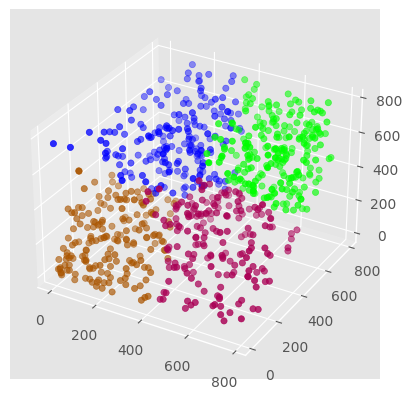

In [ ]:
model = KMeans (n_clusters = 4, random_state = 1).fit(sales_rfm_scaled)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot (111, projection = '3d')
ax.scatter(sales_rfm['R_rank'], sales_rfm['F_rank'], sales_rfm['M_rank'], cmap = "brg", c = model.predict(sales_rfm_scaled))

<Axes: xlabel='Features', ylabel='Value'>

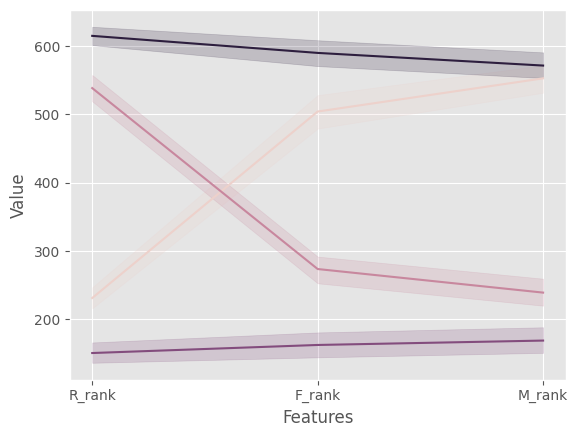

In [ ]:
melted_rfm_normalized = pd.melt(sales_rfm,
                                id_vars=['Customer_ID', 'Cluster'],
                                value_vars= ['R_rank', 'F_rank', 'M_rank'],
                                var_name= 'Features',
                                value_name= 'Value')

sns.lineplot(x = 'Features', y = 'Value', hue = 'Cluster', data = melted_rfm_normalized, legend = False)

Fuzzy Clustering

In [ ]:
pip install -U scikit-fuzzy

In [ ]:
import numpy as np
import skfuzzy as fuzz
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:
sales_rfm_fuzzy = sales_rfm.drop(columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary', 'R_rank_scaled', 'F_rank_scaled', 'M_rank_scaled', 'Cluster'])

In [ ]:
# Define the number of clusters
n_clusters = 4

# Apply fuzzy c-means clustering
cntr, model, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    sales_rfm_fuzzy.T, n_clusters, 2, error=0.005, maxiter=1000, init=None
)

In [ ]:
# Predict cluster membership for each data point
cluster_membership = np.argmax(model, axis = 0)

# Print the cluster membership for each data point
print('Cluster Membership:', cluster_membership)

Cluster Membership: [2 0 3 0 0 0 0 0 3 3 0 0 0 0 3 1 1 1 2 2 1 3 2 0 0 2 2 2 3 0 2 1 0 3 2 0 3
 2 3 3 3 1 0 2 3 1 1 0 0 1 3 0 1 3 3 1 0 2 1 1 0 1 3 0 3 3 1 0 3 2 3 1 1 1
 1 3 0 0 2 3 2 1 1 2 0 2 0 2 3 2 0 2 3 3 2 1 3 2 0 0 2 0 2 3 1 0 3 2 0 1 1
 3 0 1 2 0 2 2 1 1 3 2 2 3 0 3 2 0 3 3 0 1 0 3 1 2 1 2 2 2 3 3 2 3 0 0 1 0
 3 0 1 3 2 1 0 3 0 0 0 0 2 3 3 2 3 2 1 3 1 2 0 3 2 1 2 0 1 1 2 3 3 1 1 1 1
 3 0 0 3 0 1 3 3 0 1 1 3 1 0 0 3 0 1 3 0 0 2 3 2 0 3 0 0 0 1 1 2 3 0 2 0 2
 0 1 1 2 1 2 0 1 0 3 1 3 1 3 2 2 0 0 3 3 2 2 3 2 3 0 1 2 3 2 1 3 2 3 3 2 0
 2 1 2 3 2 0 1 1 3 3 0 1 2 1 0 3 1 3 2 1 2 0 0 0 0 0 2 1 1 0 1 2 1 1 2 1 0
 1 1 0 2 2 0 3 3 1 3 0 3 2 1 0 0 2 3 3 2 2 0 1 3 0 2 1 3 1 1 2 0 2 0 3 0 3
 2 1 3 1 2 3 3 1 3 0 0 0 3 0 0 1 2 0 2 2 3 0 1 0 0 3 2 0 2 3 0 0 3 1 0 3 3
 0 2 1 3 2 0 0 0 1 2 1 1 1 2 0 1 1 1 1 2 2 2 3 0 0 3 3 0 1 2 1 3 3 1 1 0 3
 1 0 3 0 3 1 1 0 2 1 3 2 0 0 2 3 0 2 2 1 1 1 0 0 2 1 2 1 3 1 0 1 3 3 0 1 0
 3 2 3 1 1 2 3 2 2 0 1 3 1 2 1 2 0 3 1 2 1 2 1 3 0 3 2 3 1 3 0 1 0 2 1 2 0
 1 0 

In [ ]:
# Print the cluster centers
print('Cluster Centers:', cntr)

Cluster Centers: [[599.41346823 612.52031118 576.67676693]
 [258.76902289 505.12585501 538.73864396]
 [157.27918587 146.43878503 157.04745065]
 [527.84445178 285.05382183 260.24834321]]


In [ ]:
# Create a cluster label column in the original DataFrame
cluster_labels = cluster_membership

In [ ]:
sales_rfm_fuzzy = sales_rfm.assign(K_Cluster = cluster_labels)
# Calculate average RFM values and sizes for each cluster:
sales_rfm_fuzzy.groupby('Cluster').agg({'Recency': 'mean','Frequency': 'mean','Monetary': ['mean', 'count'],})

Recency  Frequency     Monetary      
               mean       mean         mean count
Cluster                                          
0        281.185567   9.304124  7152.570722   194
1         59.449198   5.529412  1423.334866   187
2        460.234973   3.896175   938.779617   183
3         37.754464  11.044643  8100.912902   224

In [ ]:
# SIL.F (sales_rfm_fuzzy, U, alpha, distance)

In [ ]:
# FUZZY METHOD 2
# import numpy as np
# from fcmeans import FCM
# arr = np.array(sales_rfm_fuzzy)
# my_model = FCM(n_clusters = 4)
# my_model.fit(arr) ## X, numpy array. rows:samples columns:features


In [ ]:
# centers = my_model.centers
# centers

In [ ]:
# labels = my_model.predict(arr)
# labels

# ANN

In [ ]:
data = pd.read_excel(io.BytesIO(uploaded['DATA_2018_2021 V2.xlsx']))
data.head()

In [ ]:
import pandas as pd
import numpy as np


# create a new column called 'Random Column'
data['Subscription'] = np.random.randint(2, size=len(data))

# print the updated dataframe
print(data)


In [ ]:
sales_rf = sales_recency.merge(sales_frequency, on = 'Customer_ID')
sales_rfm = sales_rf.merge(sales_monetary, on = 'Customer_ID').drop(columns = 'Last Purchase Date')
data = sales_rfm.merge(data, on = 'Customer_ID')

data.head(10)

In [ ]:
data_Print = data[data['Category'] == 'Printing and Stationery']

In [ ]:
data_new = data_Print.drop(columns = ['Sn', 'Customer Name', 'Product_ID', 'Product_Name', 'City', 'Order Date', 'Order_ID', 'Ship Date', 'Country', 'Category', 'Sales', 'Profit', 'Segment', 'Sub-Category', 'State', 'Postal Code','Region'])
data_new

,Customer_ID,Recency,Frequency,Monetary,Quantity,Subscription
0,10016,1394,3,828.888,2,1
2,10016,1394,3,828.888,3,1
3,10016,1394,3,828.888,3,0
6,10031,12,7,3198.916,8,0
7,10031,12,7,3198.916,3,0
...,...,...,...,...,...,...
9975,21911,54,17,7454.435,2,1
9976,21926,202,4,376.288,2,0
9978,21926,202,4,376.288,4,0
9983,21926,202,4,376.288,2,1


In [ ]:
data1 = data_new.groupby(by = 'Customer_ID', as_index = False)['Quantity'].sum()
data1

,Customer_ID,Quantity
0,10016,8
1,10031,29
2,10046,38
3,10061,40
4,10076,51
...,...,...
783,21866,75
784,21881,43
785,21896,23
786,21911,50


In [ ]:
data_new = data_Print.drop(columns = ['Sn', 'Customer Name', 'Product_ID', 'Product_Name', 'City', 'Order Date', 'Order_ID', 'Ship Date', 'Country', 'Category', 'Sales', 'Profit', 'Segment', 'Sub-Category', 'State', 'Postal Code', 'Quantity','Region'])
data_new = data_new.drop_duplicates(subset = "Customer_ID", keep = "first")
data_new

,Customer_ID,Recency,Frequency,Monetary,Subscription
0,10016,1394,3,828.888,1
6,10031,12,7,3198.916,0
17,10046,117,6,2033.338,0
27,10061,55,12,19743.004,1
45,10076,34,13,3978.135,0
...,...,...,...,...,...
9897,21866,43,21,4934.914,0
9925,21881,9,8,42208.788,0
9937,21896,4,5,22683.600,1
9945,21911,54,17,7454.435,1


In [ ]:
data_new = data1.merge(data_new, on = 'Customer_ID')
data_new

,Customer_ID,Quantity,Recency,Frequency,Monetary,Subscription
0,10016,8,1394,3,828.888,1
1,10031,29,12,7,3198.916,0
2,10046,38,117,6,2033.338,0
3,10061,40,55,12,19743.004,1
4,10076,51,34,13,3978.135,0
...,...,...,...,...,...,...
783,21866,75,43,21,4934.914,0
784,21881,43,9,8,42208.788,0
785,21896,23,4,5,22683.600,1
786,21911,50,54,17,7454.435,1


In [ ]:
# generate churn column based on r,f, and m values
# Define the cutoffs for each RFM score
recency_cutoff = 180

# Create a function to apply the cutoffs to the RFM scores and generate a churn column
def generate_churn_column(row):
    if row["Recency"] > recency_cutoff:
        return 1
    else:
        return 0

# Apply the function to each row of the dataset to generate the churn column
data_new["Churn"] = data_new.apply(generate_churn_column, axis = 1)

In [ ]:
Customer_ID = data_new.groupby('Customer_ID').ngroup() + 1
data_new['Customer_ID'] = Customer_ID
data_new = data_new.drop(columns = ['Customer_ID', 'Recency'])
data_new.head(5)

,Quantity,Frequency,Monetary,Subscription,Churn
0,8,3,828.888,1,1
1,29,7,3198.916,0,0
2,38,6,2033.338,0,0
3,40,12,19743.004,1,0
4,51,13,3978.135,0,0


In [ ]:
data_new

,Quantity,Frequency,Monetary,Subscription,Churn
0,8,3,828.888,1,1
1,29,7,3198.916,0,0
2,38,6,2033.338,0,0
3,40,12,19743.004,1,0
4,51,13,3978.135,0,0
...,...,...,...,...,...
783,75,21,4934.914,0,0
784,43,8,42208.788,0,0
785,23,5,22683.600,1,0
786,50,17,7454.435,1,0


In [ ]:
data_new.to_excel('ann.xlsx')
files.download('ann.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_new.isnull().sum()

Quantity        0
Frequency       0
Monetary        0
Subscription    0
Churn           0
dtype: int64

In [ ]:
# numerical variables
num = list(data_new.select_dtypes(include=['int64','float64']).keys())
print(num)

['Quantity', 'Frequency', 'Monetary', 'Subscription', 'Churn']


In [ ]:
# categorical variables
cat = list(data_new.select_dtypes(include='O').keys())
print(cat)

[]


In [ ]:
# value counts of the categorical columns
for i in cat:
    print(data[i].value_counts())

In [ ]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
# data_new['State'] = label.fit_transform(data_new['State'])
#data_new['Region'] = label.fit_transform(data_new['Region'])
# data_new['Postal Code'] = label.fit_transform(data_new['Postal Code'])

In [ ]:
# scale the entire data using min-max scaling
scale_cols = ['Quantity', 'Frequency', 'Monetary']
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
data_new[scale_cols] = scale.fit_transform(data_new[scale_cols])

In [ ]:
# independent and dependent variables
x = data_new.drop('Churn',axis = 1)
y = data_new['Churn']

In [ ]:
# split the data into train and test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 10)
print(xtrain.shape)
print(xtest.shape)

(551, 4)
(237, 4)


In [ ]:
# create an artificial neural network
import tensorflow as tf
from tensorflow import keras

In [ ]:
# define sequential model
model = keras.Sequential([
    # input layer
    keras.layers.Dense(9, input_shape = (4,), activation = 'relu'),
    keras.layers.Dense(7, activation = 'relu'),
    keras.layers.Dense(5, activation = 'relu'),
    keras.layers.Dense(5, activation = 'relu'),
    # we use sigmoid for binary output
    # output layer
    keras.layers.Dense(1, activation = 'sigmoid')
]
)

In [ ]:
# time for compilation of neural net.
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
# now we fit our model to training data
model.fit(xtrain, ytrain, epochs = 50)

Epoch 1/50
18/18 [==============================] - 1s 3ms/step - loss: 0.6899 - accuracy: 0.6171
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6808 - accuracy: 0.6733
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6713 - accuracy: 0.6733
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6601 - accuracy: 0.6733
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6467 - accuracy: 0.6733
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6386 - accuracy: 0.6733
Epoch 7/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6330 - accuracy: 0.6733
Epoch 8/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6300 - accuracy: 0.6733
Epoch 9/50
18/18 [==============================] - 0s 3ms/step - loss: 0.6281 - accuracy: 0.6733
Epoch 10/50
18/18 [==============================] - 0s 2ms/step - loss: 0.6259 - accuracy: 0.6733
Epoch 11/50
18/18 [

In [ ]:
# evalute the model
model.evaluate(xtest, ytest)

8/8 [==============================] - 0s 2ms/step - loss: 0.6554 - accuracy: 0.6287


[0.6554125547409058, 0.6286919713020325]

In [ ]:
# predict the churn values
ypred = model.predict(xtest)
ypred

df = pd.DataFrame(ypred)
df

8/8 [==============================] - 0s 3ms/step


,0
0,0.332283
1,0.434713
2,0.396627
3,0.193540
4,0.177771
...,...
232,0.273056
233,0.183463
234,0.413182
235,0.311658


In [ ]:
# unscaling the ypred values
ypred_lis = []
for i in ypred:
    if i>0.39:
        ypred_lis.append(1)
    else:
        ypred_lis.append(0)
print(ypred_lis)

[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]


In [ ]:
# make dataframe for comparing the orignal and predict values
data = {'orignal_churn':ytest, 'predicted_churn':ypred_lis}
df_check = pd.DataFrame(data)
df_check

,orignal_churn,predicted_churn
692,1,0
172,1,1
768,1,1
176,1,0
647,0,0
...,...,...
441,0,0
47,0,0
660,0,1
547,0,0


In [ ]:
#df_check.to_excel('x.xlsx')
#files.download('x.xlsx')

Performance Metrics

              precision    recall  f1-score   support

           0       0.70      0.69      0.69       144
           1       0.53      0.54      0.53        93

    accuracy                           0.63       237
   macro avg       0.61      0.61      0.61       237
weighted avg       0.63      0.63      0.63       237



Text(183.22222222222223, 0.5, 'True_number')

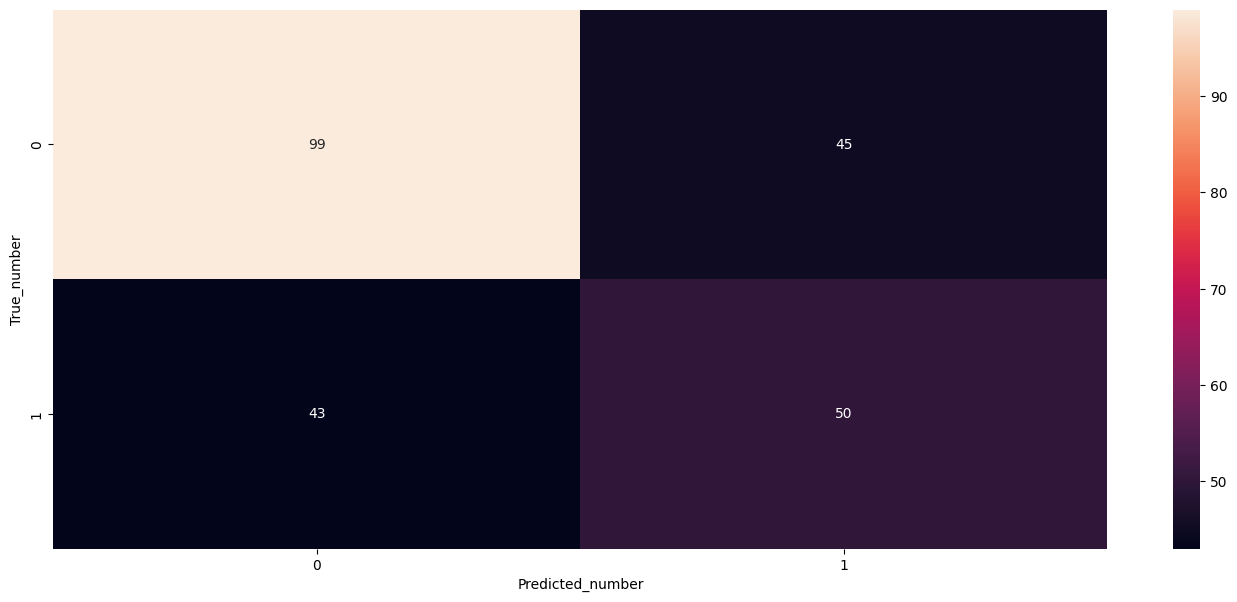

In [ ]:
# importing classification_report and confusion metrics
from sklearn.metrics import confusion_matrix, classification_report
# print classification_report
print(classification_report(ytest, ypred_lis))
# ploting the confusion metrics plot
conf_mat = tf.math.confusion_matrix(labels = ytest, predictions = ypred_lis)
plt.figure(figsize = (17,7))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted_number')
plt.ylabel('True_number')

# Recommendation System

In [ ]:
data = pd.read_excel(io.BytesIO(uploaded['DATA_2018_2021 V2.xlsx']))
data.head()

data['Category'] = data['Category'].replace('Assets & Non Lasting Items', 1)
data['Category'] = data['Category'].replace('IT Accessories , Gadget &Electronics Items', 2)
data['Category'] = data['Category'].replace('Printing and Stationery', 3)
data['Sub-Category'] = data['Sub-Category'].replace('Accessories', 1)
data['Sub-Category'] = data['Sub-Category'].replace('Appliances', 2)
data['Sub-Category'] = data['Sub-Category'].replace('Art', 3)
data['Sub-Category'] = data['Sub-Category'].replace('Binders', 4)
data['Sub-Category'] = data['Sub-Category'].replace('Bookcases', 5)
data['Sub-Category'] = data['Sub-Category'].replace('Chairs', 6)
data['Sub-Category'] = data['Sub-Category'].replace('Copiers', 7)
data['Sub-Category'] = data['Sub-Category'].replace('Envelopes', 8)
data['Sub-Category'] = data['Sub-Category'].replace('Fasteners', 9)
data['Sub-Category'] = data['Sub-Category'].replace('Furnishings', 10)
data['Sub-Category'] = data['Sub-Category'].replace('Labels', 11)
data['Sub-Category'] = data['Sub-Category'].replace('Machines', 12)
data['Sub-Category'] = data['Sub-Category'].replace('Paper', 13)
data['Sub-Category'] = data['Sub-Category'].replace('Phones', 14)
data['Sub-Category'] = data['Sub-Category'].replace('Storage', 15)
data['Sub-Category'] = data['Sub-Category'].replace('Supplies', 16)
data['Sub-Category'] = data['Sub-Category'].replace('Tables', 17)

data

In [ ]:
# recency
sales_recency = data.groupby(by = 'Customer_ID',
						as_index = False)['Order Date'].max()
sales_recency.columns = ['Customer_ID', 'Last Purchase Date']
recent_date = sales_recency['Last Purchase Date'].max()
sales_recency['Recency'] = sales_recency['Last Purchase Date'].apply(
	lambda x: (recent_date - x).days)

# frequency
sales_frequency = data.drop_duplicates().groupby(
	by=['Customer_ID'],as_index = False)['Order Date'].count()
sales_frequency.columns = ['Customer_ID', 'Frequency']

# monetary
data['Total'] = data['Sales']*data['Quantity']
sales_monetary = data.groupby(by = 'Customer_ID', as_index = False)['Total'].sum()
sales_monetary.columns = ['Customer_ID', 'Monetary']

# merging r, f and m
sales_rf = sales_recency.merge(sales_frequency, on = 'Customer_ID')
sales_rfm = sales_rf.merge(sales_monetary, on = 'Customer_ID').drop(columns = 'Last Purchase Date')

data = data.merge(sales_rfm, on = 'Customer_ID')
data


In [ ]:
pivot_table = pd.pivot_table(sales_rfm, index = 'Customer_ID', values = ['Recency', 'Frequency', 'Monetary'], fill_value = 0)
pivot_table

,Frequency,Monetary,Recency
Customer_ID,,,
10016,6,2022.480,415
10031,11,11674.552,12
10046,10,9253.880,88
10061,18,35602.580,54
10076,20,9922.265,34
...,...,...,...
21866,28,9081.214,43
21881,12,46752.992,9
21896,8,27356.926,4


In [ ]:
user_item_matrix = pivot_table.values
user_similarity = cosine_similarity(user_item_matrix)
user_similarity

array([[1.        , 0.97979434, 0.9814556 , ..., 0.97961614, 0.97985395,
        0.98527845],
       [0.97979434, 1.        , 0.99996402, ..., 0.9999994 , 0.99999994,
        0.99956299],
       [0.9814556 , 0.99996402, 1.        , ..., 0.99995586, 0.99996648,
        0.99977777],
       ...,
       [0.97961614, 0.9999994 , 0.99995586, ..., 1.        , 0.99999919,
        0.99953606],
       [0.97985395, 0.99999994, 0.99996648, ..., 0.99999919, 1.        ,
        0.99957173],
       [0.98527845, 0.99956299, 0.99977777, ..., 0.99953606, 0.99957173,
        1.        ]])

In [ ]:
user_similarity_df = pd.DataFrame(user_similarity, columns = pivot_table.index, index = pivot_table.index)
user_similarity_df

Customer_ID,10016,10031,10046,10061,10076,10091,10106,10121,10136,10151,...,21791,21806,21821,21836,21851,21866,21881,21896,21911,21926
Customer_ID,,,,,,,,,,,,,,,,,,,,,
10016,1.000000,0.979794,0.981456,0.979891,0.980273,0.979969,0.979643,0.981061,0.996921,0.982029,...,0.986760,0.999841,0.986536,0.992554,0.979715,0.980531,0.979625,0.979616,0.979854,0.985278
10031,0.979794,1.000000,0.999964,1.000000,0.999997,0.999999,0.999999,0.999979,0.992399,0.999930,...,0.999260,0.976085,0.999313,0.996849,1.000000,0.999991,0.999999,0.999999,1.000000,0.999563
10046,0.981456,0.999964,1.000000,0.999968,0.999981,0.999971,0.999957,0.999997,0.993406,0.999992,...,0.999551,0.977894,0.999591,0.997486,0.999961,0.999987,0.999956,0.999956,0.999966,0.999778
10061,0.979891,1.000000,0.999968,1.000000,0.999997,0.999999,0.999999,0.999981,0.992455,0.999935,...,0.999278,0.976189,0.999330,0.996886,0.999999,0.999991,0.999999,0.999999,1.000000,0.999577
10076,0.980273,0.999997,0.999981,0.999997,1.000000,0.999999,0.999993,0.999992,0.992699,0.999957,...,0.999350,0.976607,0.999399,0.997041,0.999996,0.999999,0.999993,0.999993,0.999997,0.999631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21866,0.980531,0.999991,0.999987,0.999991,0.999999,0.999995,0.999986,0.999996,0.992862,0.999970,...,0.999396,0.976890,0.999442,0.997143,0.999990,1.000000,0.999986,0.999986,0.999992,0.999664
21881,0.979625,0.999999,0.999956,0.999999,0.999993,0.999998,1.000000,0.999972,0.992290,0.999918,...,0.999227,0.975900,0.999281,0.996779,0.999999,0.999986,1.000000,1.000000,0.999999,0.999537
21896,0.979616,0.999999,0.999956,0.999999,0.999993,0.999997,1.000000,0.999972,0.992285,0.999918,...,0.999225,0.975890,0.999279,0.996776,1.000000,0.999986,1.000000,1.000000,0.999999,0.999536


In [ ]:
pivot_table = pd.pivot_table(data, index = 'Product_ID', values = ['Sub-Category', 'Sales'])
pivot_table

,Sales,Sub-Category
Product_ID,,
10000004,46.972000,14.000000
10000007,20.908889,13.000000
10000010,934.884000,12.000000
10000011,54.043467,11.333333
10000014,25.842750,4.000000
...,...,...
10004977,591.303333,14.000000
10004980,80.090000,2.000000
10004983,27.544000,13.000000


In [ ]:
product_similarity_matrix = pivot_table.values
product_similarity = cosine_similarity(product_similarity_matrix)
product_similarity

array([[1.        , 0.96467522, 0.96192621, ..., 0.98857474, 0.9999025 ,
        0.98439796],
       [0.96467522, 1.        , 0.85594522, ..., 0.99336258, 0.96825988,
        0.90327001],
       [0.96192621, 0.85594522, 1.        , ..., 0.90973962, 0.95801592,
        0.99500872],
       ...,
       [0.98857474, 0.99336258, 0.90973962, ..., 1.        , 0.99058317,
        0.94662878],
       [0.9999025 , 0.96825988, 0.95801592, ..., 0.99058317, 1.        ,
        0.98184492],
       [0.98439796, 0.90327001, 0.99500872, ..., 0.94662878, 0.98184492,
        1.        ]])

In [ ]:
product_similarity_df = pd.DataFrame(product_similarity, columns = pivot_table.index, index = pivot_table.index)
product_similarity_df

Product_ID,10000004,10000007,10000010,10000011,10000014,10000015,10000019,10000023,10000024,10000025,...,10004968,10004970,10004971,10004973,10004974,10004977,10004980,10004983,10004996,10004999
Product_ID,,,,,,,,,,,,,,,,,,,,,
10000004,1.000000,0.964675,0.961926,0.996561,0.990752,0.959880,0.992331,0.961913,0.992006,0.967701,...,0.987846,0.999332,0.920124,0.991862,0.994753,0.964832,0.965171,0.988575,0.999902,0.984398
10000007,0.964675,1.000000,0.855945,0.939529,0.920009,0.852100,0.989841,0.855920,0.990208,0.867103,...,0.993899,0.954406,0.990792,0.923284,0.932660,0.861498,0.862155,0.993363,0.968260,0.903270
10000010,0.961926,0.855945,1.000000,0.981265,0.990114,0.999973,0.920766,1.000000,0.919747,0.999758,...,0.907752,0.971270,0.778055,0.988895,0.984841,0.999941,0.999926,0.909740,0.958016,0.995009
10000011,0.996561,0.939529,0.981265,1.000000,0.998588,0.979814,0.978677,0.981255,0.978139,0.985262,...,0.971569,0.998923,0.884509,0.999001,0.999809,0.983295,0.983530,0.972686,0.995307,0.995592
10000014,0.990752,0.920009,0.990114,0.998588,1.000000,0.989050,0.966383,0.990107,0.965710,0.992958,...,0.957620,0.995048,0.858477,0.999964,0.999435,0.991576,0.991743,0.958981,0.988761,0.999169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10004977,0.964832,0.861498,0.999941,0.983295,0.991576,0.999834,0.924940,0.999941,0.923947,0.999938,...,0.912245,0.973792,0.784817,0.990448,0.986663,1.000000,0.999999,0.914185,0.961067,0.996032
10004980,0.965171,0.862155,0.999926,0.983530,0.991743,0.999809,0.925431,0.999926,0.924441,0.999951,...,0.912774,0.974085,0.785619,0.990625,0.986873,0.999999,1.000000,0.914709,0.961424,0.996146
10004983,0.988575,0.993363,0.909740,0.972686,0.958981,0.906646,0.999625,0.909719,0.999693,0.918645,...,0.999989,0.982408,0.968642,0.961339,0.967966,0.914185,0.914709,1.000000,0.990583,0.946629


In [ ]:
# Repeat user similarity matrix for each product
n_products = 10

In [ ]:
# Compute hybrid similarity as weighted average of user and product similarity
expanded_user_similarity = np.zeros_like(product_similarity)
expanded_user_similarity[:user_similarity.shape[0], :user_similarity.shape[1]] = user_similarity
hybrid_similarity = (0.6 * expanded_user_similarity) + (0.4 * product_similarity)

In [ ]:
hybrid_similarity_df = pd.DataFrame(hybrid_similarity, columns = pivot_table.index, index = pivot_table.index)
hybrid_similarity_df

Product_ID,10000004,10000007,10000010,10000011,10000014,10000015,10000019,10000023,10000024,10000025,...,10004968,10004970,10004971,10004973,10004974,10004977,10004980,10004983,10004996,10004999
Product_ID,,,,,,,,,,,,,,,,,,,,,
10000004,1.000000,0.973747,0.973644,0.986559,0.984465,0.971933,0.984719,0.973402,0.994955,0.976298,...,0.395138,0.399733,0.368049,0.396745,0.397901,0.385933,0.386068,0.395430,0.399961,0.393759
10000007,0.973747,1.000000,0.942357,0.975812,0.968002,0.940840,0.995936,0.942355,0.991522,0.946799,...,0.397560,0.381762,0.396317,0.369313,0.373064,0.344599,0.344862,0.397345,0.387304,0.361308
10000010,0.973644,0.942357,1.000000,0.992487,0.996034,0.999972,0.968281,0.999998,0.963942,0.999899,...,0.363101,0.388508,0.311222,0.395558,0.393936,0.399977,0.399971,0.363896,0.383206,0.398003
10000011,0.986559,0.975812,0.992487,1.000000,0.999433,0.991925,0.991470,0.992491,0.986729,0.994066,...,0.388628,0.399569,0.353804,0.399600,0.399924,0.393318,0.393412,0.389074,0.398123,0.398237
10000014,0.984465,0.968002,0.996034,0.999433,1.000000,0.995619,0.986549,0.996038,0.981903,0.997157,...,0.383048,0.398019,0.343391,0.399986,0.399774,0.396630,0.396697,0.383592,0.395504,0.399668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10004977,0.385933,0.344599,0.399977,0.393318,0.396630,0.399934,0.369976,0.399976,0.369579,0.399975,...,0.364898,0.389517,0.313927,0.396179,0.394665,0.400000,0.400000,0.365674,0.384427,0.398413
10004980,0.386068,0.344862,0.399971,0.393412,0.396697,0.399924,0.370172,0.399970,0.369777,0.399981,...,0.365110,0.389634,0.314248,0.396250,0.394749,0.400000,0.400000,0.365884,0.384569,0.398458
10004983,0.395430,0.397345,0.363896,0.389074,0.383592,0.362658,0.399850,0.363888,0.399877,0.367458,...,0.399995,0.392963,0.387457,0.384536,0.387186,0.365674,0.365884,0.400000,0.396233,0.378652


In [ ]:
def get_recommendations(Customer_ID):
    customer_index = data[data['Customer_ID'] == Customer_ID].index[0] # Get index of customer in user_item_matrix
    customer_similarities = hybrid_similarity[customer_index] # Get hybrid similarity scores for customer
    product_indices = np.argsort(customer_similarities)[::-1][:n_products] # Sort products by hybrid similarity score in descending order
    top_product_ids = [product_attributes.index[i] for i in product_indices] # Get IDs of top n similar products
    product_names = [data.loc[data['Product_ID'] == Product_ID, 'Product_Name'].values[0] for Product_ID in top_product_ids]
    recommendations_df = pd.DataFrame({'Product ID': top_product_ids, 'Product Name': product_names})
    return recommendations_df

In [ ]:
Customer_ID = 10016
n_products = 10
recommendations = get_recommendations(Customer_ID)
print(f"Top 10 recommended products for user {Customer_ID}:")
print(recommendations)

Top 10 recommended products for user 10016:
   Product ID                                       Product Name
0    10002344            Carina 42"Hx23 3/4"W Media Storage Unit
1    10003759                   Crayola Anti Dust Chalk, 12/Pack
2    10000948  GBC Laser Imprintable Binding System Covers, D...
3    10000755  Eldon Expressions Wood and Plastic Desk Access...
4    10002622  Bush Andora Conference Table, Maple/Graphite G...
5    10003174    Plantronics S12 Corded Telephone Headset System
6    10001395                   Global Leather Task Chair, Black
7    10000343  Pressboard Covers with Storage Hooks, 9 1/2" x...
8    10002602  DMI Arturo Collection Mission-style Design Woo...
9    10004768                Acme Kleencut Forged Steel Scissors


UI for Recommendation System